<a href="https://colab.research.google.com/github/Pankajd007/Business-Analytics/blob/master/Wider_Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


In this notebook, we implement [The TensorFlow 2 Object Detection Library](https://blog.tensorflow.org/2020/07/tensorflow-2-meets-object-detection-api.html) for training on our own dataset.


We will take the following steps to implement EfficientDet D0 on our custom data:
* Install TensorFlow2 Object Detection Dependencies
* Download Custom TensorFlow2 Object Detection Dataset
* Write Custom TensorFlow2 Object Detection Training Configuation
* Train Custom TensorFlow2 Object Detection Model
* Export Custom TensorFlow2 Object Detection Weights
* Use Trained TensorFlow2 Object Detection For Inference on Test Images

# Install TensorFlow2 Object Detection Dependencies


In [ ]:
import os
import pathlib
# Clear any logs from previous runs

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2415, done.
remote: Counting objects: 100% (2415/2415), done.
remote: Compressing objects: 100% (2023/2023), done.
remote: Total 2415 (delta 577), reused 1375 (delta 364), pack-reused 0
Receiving objects: 100% (2415/2415), 30.78 MiB | 25.84 MiB/s, done.
Resolving deltas: 100% (577/577), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1618454 sha256=0b88aad28f2ee1e3ed45d2716399012ad977cc8340077d6fb3052a58fdc92870
  Stored in directory: /tmp/pip-ephem-wheel-cache-fvo57r2o/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.1-cp36-none-any.whl size=43734 sha256=4a3af66df8e09e5906f5b5409a4c66d70cd8f6f20f54192eaadb64780faa009a
  Stored in directory: /root/.cache/pip/wheels/65/fe/90/20d6d6d97223d80d20cb390be636619c536edab5658c12bdba
  Created wheel for hdfs: filename=hdfs-2.5.8-cp36-none-any.whl size=33213 sha256=edeef2e66a0281365398d57f6d7d4859ac82276d601e0ce08f2cffebb10d7568
  Stored in directory: /root/.cache/pip/wheels/fe/a7/05/23e3699975fc20f8a30e00ac1e515ab8c61168e982abe4ce70
  Created wheel for dill: filename=dill-0.3.1.1-cp36-none-any.whl size=78533 sha256=f4c8b58e4c5efc1eea0f0812ee2254f3ed36b0c5b167a55b8c9a538b9c

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.27.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
#run model builder test
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py


2021-02-14 04:07:29.508210: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model
2021-02-14 04:07:31.927993: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-02-14 04:07:31.928963: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-02-14 04:07:31.994115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-02-14 04:07:31.994707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB devic

# Prepare Tensorflow 2 Object Detection Training Data


In [ ]:
!git clone https://github.com/qdraw/tensorflow-face-object-detector-tutorial

Cloning into 'tensorflow-face-object-detector-tutorial'...
remote: Enumerating objects: 61, done.
remote: Total 61 (delta 0), reused 0 (delta 0), pack-reused 61
Unpacking objects: 100% (61/61), done.


In [ ]:
import requests
import os
import shutil

"""
Script to download
Wider Face Training Images
Wider Face Validation Images
from Google Drive using Python3.6

http://mmlab.ie.cuhk.edu.hk/projects/WIDERFace/

Wider_face_split is included in repo

"""

# credits: https://stackoverflow.com/a/16664766
# https://stackoverflow.com/questions/16664526/howto-download-file-from-drive-api-using-python-script

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)


# The script
curr_path = os.getcwd()
models_path = os.path.join(curr_path,"data")

# make dir => wider_data in folder
try:
    os.makedirs(models_path)
except Exception as e:
    pass

if os.path.exists(os.path.join(models_path,"train.zip")) == False:
    print("downloading.. train.zip -- 1.47GB")
    download_file_from_google_drive("0B6eKvaijfFUDQUUwd21EckhUbWs", os.path.join(models_path,"train.zip"))

if os.path.exists(os.path.join(models_path,"val.zip")) == False:
    print("downloading.. val.zip -- 362.8MB")
    download_file_from_google_drive("0B6eKvaijfFUDd3dIRmpvSk8tLUk", os.path.join(models_path,"val.zip"))

print("files downloaded")

# unzip the files
import zipfile

if os.path.exists(os.path.join(models_path,"WIDER_train")) == False:
    with zipfile.ZipFile(os.path.join(models_path,"train.zip"),"r") as zip_ref:
        zip_ref.extractall(models_path)

if os.path.exists(os.path.join(models_path,"WIDER_val")) == False:
    with zipfile.ZipFile(os.path.join(models_path,"val.zip"),"r") as zip_ref:
        zip_ref.extractall(models_path)

print("files unziped")






downloading.. train.zip -- 1.47GB
downloading.. val.zip -- 362.8MB
files downloaded
files unziped


In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
%cd data

/content/data


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving face_label.pbtxt to face_label.pbtxt


In [ ]:
!pwd

/content/data


In [ ]:
# Upload the wider_face_split.zip from local machine
from google.colab import files
uploaded = files.upload()

Saving wider_face_split.zip to wider_face_split.zip


In [ ]:
#Extract the zip file into data folder
if os.path.exists(os.path.join(os.getcwd(),"wider_face_split")) == False:
    with zipfile.ZipFile(os.path.join(os.getcwd(),"wider_face_split.zip"),"r") as zip_ref:
        zip_ref.extractall(os.getcwd())

In [ ]:
!pwd

/content/data


## Converting XML files from images.

In [ ]:
#!/usr/bin/env python3
import os
os.chdir('/content')
"""
This script crawls over 9263 training images and 1873 items
On my Macbook pro this takes: 4 minutes

"""
import cv2
import os
import numpy as np
from glob import iglob # python 3.5 or newer
from shutil import copyfile


# The script
curr_path = os.getcwd()

import xml.etree.cElementTree as ET

# settings
cnt = 0
hog = cv2.HOGDescriptor((80, 80), (16, 16), (8,8), (8,8), 9)
# data = []
# label = []


def newXMLPASCALfile(imageheight, imagewidth, path, basename):
    # print(filename)
    annotation = ET.Element("annotation", verified="yes")
    ET.SubElement(annotation, "folder").text = "images"
    ET.SubElement(annotation, "filename").text = basename
    ET.SubElement(annotation, "path").text = path

    source = ET.SubElement(annotation, "source")
    ET.SubElement(source, "database").text = "test"

    size = ET.SubElement(annotation, "size")
    ET.SubElement(size, "width").text = str(imagewidth)
    ET.SubElement(size, "height").text = str(imageheight)
    ET.SubElement(size, "depth").text = "3"

    ET.SubElement(annotation, "segmented").text = "0"

    tree = ET.ElementTree(annotation)
    # tree.write("filename.xml")
    return tree

def appendXMLPASCAL(curr_et_object,x1, y1, w, h, filename):
    et_object = ET.SubElement(curr_et_object.getroot(), "object")
    ET.SubElement(et_object, "name").text = "face"
    ET.SubElement(et_object, "pose").text = "Unspecified"
    ET.SubElement(et_object, "truncated").text = "0"
    ET.SubElement(et_object, "difficult").text = "0"
    bndbox = ET.SubElement(et_object, "bndbox")
    ET.SubElement(bndbox, "xmin").text = str(x1)
    ET.SubElement(bndbox, "ymin").text = str(y1)
    ET.SubElement(bndbox, "xmax").text = str(x1+w)
    ET.SubElement(bndbox, "ymax").text = str(y1+h)
    filename = filename.strip().replace(".jpg",".xml")
    curr_et_object.write(filename)
    return curr_et_object




def readAndWrite(bbx_gttxtPath):
    cnt = 0
    with open(bbx_gttxtPath, 'r') as f:
        curr_img = ''

        curr_filename = ""
        curr_path = ""

        curr_et_object = ET.ElementTree()


        img = np.zeros((80, 80))
        for line in f:
            inp = line.split(' ')

            # if line.find("--") != -1:
            #     curr_filename = line.split('--')[1]
            #     # reset elements
            #     # emptyEl = ET.Element("")
            #     curr_et_object = ET.ElementTree()

            if len(inp)==1:
                img_path = inp[0]
                img_path = img_path[:-1]
                curr_img = img_path
                if curr_img.isdigit():
                    continue
                # print(Train_path+'/'+curr_img)
                img = cv2.imread(Train_path + '/' + curr_img, 2) # POSIX only
                # print( len(list(curr_et_object.getroot()) )  )
                curr_filename = curr_img.split("/")[1].strip()
                curr_path = os.path.join(Train_path, os.path.dirname(curr_img))
                curr_et_object = newXMLPASCALfile(img.shape[0],img.shape[1],curr_path, curr_filename )
                # print( curr_et_object  )

            else:
                # print(img)
                inp = [int(i) for i in inp[:-1]]
                x1, y1, w, h, blur, expression, illumination, invalid, occlusion, pose = inp
                n = max(w,h)
                if invalid == 1 or blur > 0 or n < 50:
                    continue
                img2 = img[y1:y1+n, x1:x1+n]
                img3 = cv2.resize(img2, (80, 80))
                vec = hog.compute(img3)
                # data.append(vec)
                # label.append(1)
                cnt += 1

                fileNow = os.path.join(curr_path,curr_filename)
                print("{}: {} {} {} {}".format(len(vec),x1, y1, w, h) + " " + fileNow)

                curr_et_object = appendXMLPASCAL(curr_et_object,x1, y1, w, h, fileNow )


# ################################ TRAINING DATA 9263 ITEMS ##################################
# # # Run Script for Training data
Train_path = os.path.join(curr_path, "data", "WIDER_train", "images" )
## comment this out
bbx_gttxtPath = os.path.join(curr_path, "data", "wider_face_split", "wider_face_train_bbx_gt.txt" )
readAndWrite(bbx_gttxtPath)


# To folders:
to_xml_folder = os.path.join(curr_path, "data", "tf_wider_train", "annotations", "xmls" )
to_image_folder = os.path.join(curr_path, "data", "tf_wider_train", "images" )

# make dir => wider_data in folder
try:
    os.makedirs(to_xml_folder)
    os.makedirs(to_image_folder)
except Exception as e:
    pass

rootdir_glob = Train_path + '/**/*' # Note the added asterisks # This will return absolute paths
file_list = [f for f in iglob(rootdir_glob, recursive=True) if os.path.isfile(f)]

train_annotations_index = os.path.join(curr_path, "data", "tf_wider_train", "annotations", "train.txt" )

with open(train_annotations_index, "a") as indexFile:
    for f in file_list:
        if ".xml" in f:
            print(f)
            copyfile(f, os.path.join(to_xml_folder, os.path.basename(f) ))
            img = f.replace(".xml",".jpg")
            copyfile(img, os.path.join(to_image_folder, os.path.basename(img) ))
            indexFile.write(os.path.basename(f.replace(".xml","")) + "\n")


################################ VALIDATION DATA 1873 ITEMS ##################################

# Run Script for Validation data
Train_path = os.path.join(curr_path, "data", "WIDER_val", "images" )
bbx_gttxtPath = os.path.join(curr_path, "data", "wider_face_split", "wider_face_val_bbx_gt.txt" )
readAndWrite(bbx_gttxtPath)


# To folders:
to_xml_folder = os.path.join(curr_path, "data", "tf_wider_val", "annotations", "xmls" )
to_image_folder = os.path.join(curr_path, "data", "tf_wider_val", "images" )

# make dir => wider_data in folder
try:
    os.makedirs(to_xml_folder)
    os.makedirs(to_image_folder)
except Exception as e:
    pass


rootdir_glob = Train_path + '/**/*' # Note the added asterisks # This will return absolute paths
file_list = [f for f in iglob(rootdir_glob, recursive=True) if os.path.isfile(f)]

train_annotations_index = os.path.join(curr_path, "data", "tf_wider_val", "annotations", "val.txt" )

with open(train_annotations_index, "a") as indexFile:
    for f in file_list:
        if ".xml" in f:
            print(f)
            copyfile(f, os.path.join(to_xml_folder, os.path.basename(f) ))
            img = f.replace(".xml",".jpg")
            copyfile(img, os.path.join(to_image_folder, os.path.basename(img) ))
            indexFile.write(os.path.basename(f.replace(".xml","")) + "\n")


Streaming output truncated to the last 5000 lines.
2916: 742 143 40 58 /content/data/WIDER_val/images/16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_25.jpg
2916: 932 151 38 60 /content/data/WIDER_val/images/16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_25.jpg
2916: 456 91 103 147 /content/data/WIDER_val/images/16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_589.jpg
2916: 387 264 96 156 /content/data/WIDER_val/images/16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_305.jpg
2916: 592 279 90 132 /content/data/WIDER_val/images/16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_305.jpg
2916: 434 165 250 356 /content/data/WIDER_val/images/16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_84.jpg
2916: 291 159 381 510 /content/data/WIDER_val/images/16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_422.jpg
2916: 351 212 357 484 /content/data/WIDER_val/images/16--Award_Ceremony/16_Award_Ceremony_Awards_Ceremony_16_474.jpg
2916: 313 307 376 539 /

## Converting XML file into csv

In [ ]:
!python /content/tensorflow-face-object-detector-tutorial/003_xml-to-csv.py

> tf_wider_train - Successfully converted xml to csv.
> tf_wider_val -  Successfully converted xml to csv.


# Generating tf.records files to feed into model.

In [ ]:
!python tensorflow-face-object-detector-tutorial/004_generate_tfrecord.py --images_path=data/tf_wider_train/images --csv_input=data/tf_wider_train/train.csv  --output_path=data/train.record


2020-12-27 07:45:47.814303: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Successfully created the TFRecords: /content/data/train.record


In [ ]:
!python /content/tensorflow-face-object-detector-tutorial/004_generate_tfrecord.py --images_path=data/tf_wider_val/images --csv_input=data/tf_wider_val/val.csv  --output_path=data/val.record


2020-12-27 07:45:59.759761: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Successfully created the TFRecords: /content/data/val.record


In [ ]:
%cat /content/models/research/deploy/pipeline_file.config

cat: /content/models/research/deploy/pipeline_file.config: No such file or directory


In [ ]:
test_record_fname = '/content/data/val.record'
train_record_fname = '/content/data/train.record'
label_map_pbtxt_fname = '/content/data/face_label.pbtxt'

# Configure Custom TensorFlow2 Object Detection Training Configuration




> In this section you can specify any model in the [TF2 OD model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) and set up your training configuration.



In [ ]:
##change chosen model to deploy different models available in the TF2 object detection zoo
MODELS_CONFIG = {
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
        'batch_size': 8
    },
    'efficientdet-d1': {
        'model_name': 'efficientdet_d1_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d1_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
    'efficientdet-d2': {
        'model_name': 'efficientdet_d2_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d2_768x768_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d2_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
        'efficientdet-d3': {
        'model_name': 'efficientdet_d3_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d3_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d3_coco17_tpu-32.tar.gz',
        'batch_size': 16
    }
}

#in this tutorial we implement the lightweight, smallest state of the art efficientdet model
#if you want to scale up tot larger efficientdet models you will likely need more compute!
chosen_model = 'efficientdet-d0'

num_steps = 4000 #The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 50 #Perform evaluation after so many steps

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up your training

In [ ]:
#download pretrained weights
%mkdir /content/models/research/deploy/
%cd /content/models/research/deploy/
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

/content/models/research/deploy
--2020-12-27 07:46:04--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.28.128, 2607:f8b0:400e:c04::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.28.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz’

efficientdet_d0_coc 100%[===================>]  29.31M   166MB/s    in 0.2s    

2020-12-27 07:46:04 (166 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz’ saved [30736482/30736482]



In [ ]:
%cat /content/models/research/deploy/pipeline_file.config

cat: /content/models/research/deploy/pipeline_file.config: No such file or directory


In [ ]:
#download base training configuration file
%cd /content/models/research/deploy
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

/content/models/research/deploy
--2020-12-27 07:46:05--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4630 (4.5K) [text/plain]
Saving to: ‘ssd_efficientdet_d0_512x512_coco17_tpu-8.config’

ssd_efficientdet_d0 100%[===================>]   4.52K  --.-KB/s    in 0s      

2020-12-27 07:46:05 (74.3 MB/s) - ‘ssd_efficientdet_d0_512x512_coco17_tpu-8.config’ saved [4630/4630]



In [ ]:
%cat /content/models/research/deploy/ssd_efficientdet_d0_512x512_coco17_tpu-8.config

 # SSD with EfficientNet-b0 + BiFPN feature extractor,
# shared box predictor and focal loss (a.k.a EfficientDet-d0).
# See EfficientDet, Tan et al, https://arxiv.org/abs/1911.09070
# See Lin et al, https://arxiv.org/abs/1708.02002
# Trained on COCO, initialized from an EfficientNet-b0 checkpoint.
#
# Train on TPU-8

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 90
    add_background_class: false
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      

In [ ]:
#prepare
pipeline_fname = '/content/models/research/deploy/' + base_pipeline_file
fine_tune_checkpoint = '/content/models/research/deploy/' + model_name + '/checkpoint/ckpt-0'
num_classes = 1

In [ ]:
#write custom configuration file by slotting our dataset, model checkpoint, and training parameters into the base pipeline file

import re

%cd /content/models/research/deploy
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    
    #fine-tune checkpoint type
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
        
    f.write(s)



/content/models/research/deploy
writing custom configuration file


In [ ]:
%cat /content/models/research/deploy/pipeline_file.config

 # SSD with EfficientNet-b0 + BiFPN feature extractor,
# shared box predictor and focal loss (a.k.a EfficientDet-d0).
# See EfficientDet, Tan et al, https://arxiv.org/abs/1911.09070
# See Lin et al, https://arxiv.org/abs/1708.02002
# Trained on COCO, initialized from an EfficientNet-b0 checkpoint.
#
# Train on TPU-8

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 1
    add_background_class: false
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      m

# Train Custom TF2 Object Detector

* pipeline_file: defined above in writing custom training configuration
* model_dir: the location tensorboard logs and saved model checkpoints will save to
* num_train_steps: how long to train for
* num_eval_steps: perform eval on validation set after this many steps







In [ ]:
pipeline_file = '/content/models/research/deploy/pipeline_file.config'
model_dir = '/content/training'

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

2020-12-27 07:46:06.140076: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2020-12-27 07:46:08.823842: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2020-12-27 07:46:08.825919: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2020-12-27 07:46:08.868267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-27 07:46:08.868897: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-12-27 07:46:08.868942: I tensorflow/stream_executor/platform/default/dso_loade

In [ ]:
#run model evaluation to obtain performance metrics
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --checkpoint_dir={model_dir} 
#Not yet implemented for EfficientDet

2020-12-27 08:34:32.944242: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
W1227 08:34:36.235029 139723806758784 model_lib_v2.py:1026] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I1227 08:34:36.235258 139723806758784 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I1227 08:34:36.235355 139723806758784 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I1227 08:34:36.235445 139723806758784 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W1227 08:34:36.235582 139723806758784 model_lib_v2.py:1041] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2020-12-27 08:34:36.245637: I tensorflow/compiler/jit/xla

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir '/content/training/train'

<IPython.core.display.Javascript object>

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir '/content/training/eval'

<IPython.core.display.Javascript object>

# Run Inference on Test Images with Custom TensorFlow2 Object Detector

In [ ]:
#export dataset above with format COCO JSON
#or import your test images via other means. 

In [ ]:
os.chdir('/content')

In [ ]:
Test_path = os.path.join(curr_path, "data", "tf_wider_val", "images" )
rootdir_glob = Test_path + '/**/*' # Note the added asterisks # This will return absolute paths
file_list = [f for f in iglob(rootdir_glob, recursive=True) if os.path.isfile(f)]

In [ ]:

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
%ls '/content/training/'

checkpoint                  ckpt-3.data-00000-of-00001  ckpt-5.index
ckpt-1.data-00000-of-00001  ckpt-3.index                eval/
ckpt-1.index                ckpt-4.data-00000-of-00001  train/
ckpt-2.data-00000-of-00001  ckpt-4.index
ckpt-2.index                ckpt-5.data-00000-of-00001


In [ ]:
#recover our saved model
pipeline_config = pipeline_file
#generally you want to put the last ckpt from training in here
model_dir = '/content/training/ckpt-5'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join('/content/training/ckpt-5'))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [ ]:
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

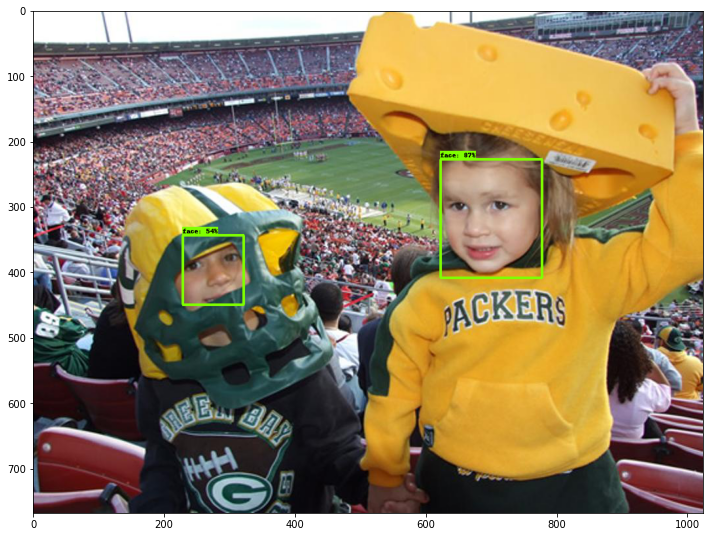

In [ ]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random
image_path = random.choice(file_list)
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.5,
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()